In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Using device: cuda


## 데이터 로드

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## evaluation module 정의

In [ ]:
def plot_confusion_matrix(true_labels, pred_labels, classes):
   # 혼동 행렬 계산
   cm = confusion_matrix(true_labels, pred_labels)

   # 정규화된 혼동 행렬
   cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

   # 두 개의 서브플롯 생성
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

   # 원본 혼동 행렬 시각화
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
               xticklabels=classes, yticklabels=classes)
   ax1.set_title('Confusion Matrix')
   ax1.set_xlabel('Predicted')
   ax1.set_ylabel('True')

   # 정규화된 혼동 행렬 시각화
   sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax2,
               xticklabels=classes, yticklabels=classes)
   ax2.set_title('Normalized Confusion Matrix')
   ax2.set_xlabel('Predicted')
   ax2.set_ylabel('True')

   plt.tight_layout()
   plt.show()

In [ ]:
# 평가 함수 정의
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Accuracy 계산
    accuracy = (all_preds == all_labels).mean()

    # Precision, Recall, F1-score 계산
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    # ROC AUC 계산 (one-vs-rest)
    roc_auc = roc_auc_score(
        np.eye(10)[all_labels], all_probs, multi_class='ovr', average='weighted'
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

## Simple CNN 모델 정의

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## model training

In [ ]:
# 모델 학습 함수
def train_model(model, trainloader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}")):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

In [ ]:
model = SimpleCNN().to(device)

# 모델 학습
print("Starting training...")
train_model(model, trainloader)
print("Training completed!")

Starting training...


Epoch 1:  27%|██▋       | 105/391 [00:03<00:09, 30.13it/s]

[1,   100] loss: 2.303


Epoch 1:  52%|█████▏    | 202/391 [00:06<00:08, 23.45it/s]

[1,   200] loss: 2.301


Epoch 1:  77%|███████▋  | 303/391 [00:11<00:03, 26.16it/s]

[1,   300] loss: 2.300


Epoch 2:  26%|██▌       | 102/391 [00:04<00:12, 23.32it/s]

[2,   100] loss: 2.297


Epoch 2:  52%|█████▏    | 205/391 [00:08<00:05, 31.61it/s]

[2,   200] loss: 2.294


Epoch 2:  78%|███████▊  | 305/391 [00:11<00:02, 31.98it/s]

[2,   300] loss: 2.289


Epoch 3:  27%|██▋       | 104/391 [00:03<00:12, 23.84it/s]

[3,   100] loss: 2.266


Epoch 3:  52%|█████▏    | 203/391 [00:07<00:05, 32.35it/s]

[3,   200] loss: 2.245


Epoch 3:  77%|███████▋  | 302/391 [00:11<00:04, 21.00it/s]

[3,   300] loss: 2.222


Epoch 4:  26%|██▋       | 103/391 [00:04<00:09, 30.41it/s]

[4,   100] loss: 2.159


Epoch 4:  52%|█████▏    | 202/391 [00:08<00:13, 14.50it/s]

[4,   200] loss: 2.129


Epoch 4:  77%|███████▋  | 303/391 [00:13<00:03, 24.25it/s]

[4,   300] loss: 2.089


Epoch 5:  26%|██▋       | 103/391 [00:03<00:09, 29.65it/s]

[5,   100] loss: 2.020


Epoch 5:  52%|█████▏    | 205/391 [00:06<00:06, 30.55it/s]

[5,   200] loss: 1.990


Epoch 5:  77%|███████▋  | 301/391 [00:10<00:04, 20.95it/s]

[5,   300] loss: 1.964


Epoch 5: 100%|██████████| 391/391 [00:14<00:00, 27.77it/s]

Training completed!


## model evaluation

In [ ]:
# 평가 지표 계산
print("\nCalculating metrics...")
metrics = evaluate_model(model, testloader)

# 결과 출력
print("\nFinal Metrics:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")
print(f"ROC AUC: {metrics['roc_auc']:.4f}")


Calculating metrics...


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 26.81it/s]


Final Metrics:
Accuracy: 0.2878
Precision: 0.2667
Recall: 0.2878
F1 Score: 0.2452
ROC AUC: 0.7595


In [ ]:
# 클래스별 성능 분석
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

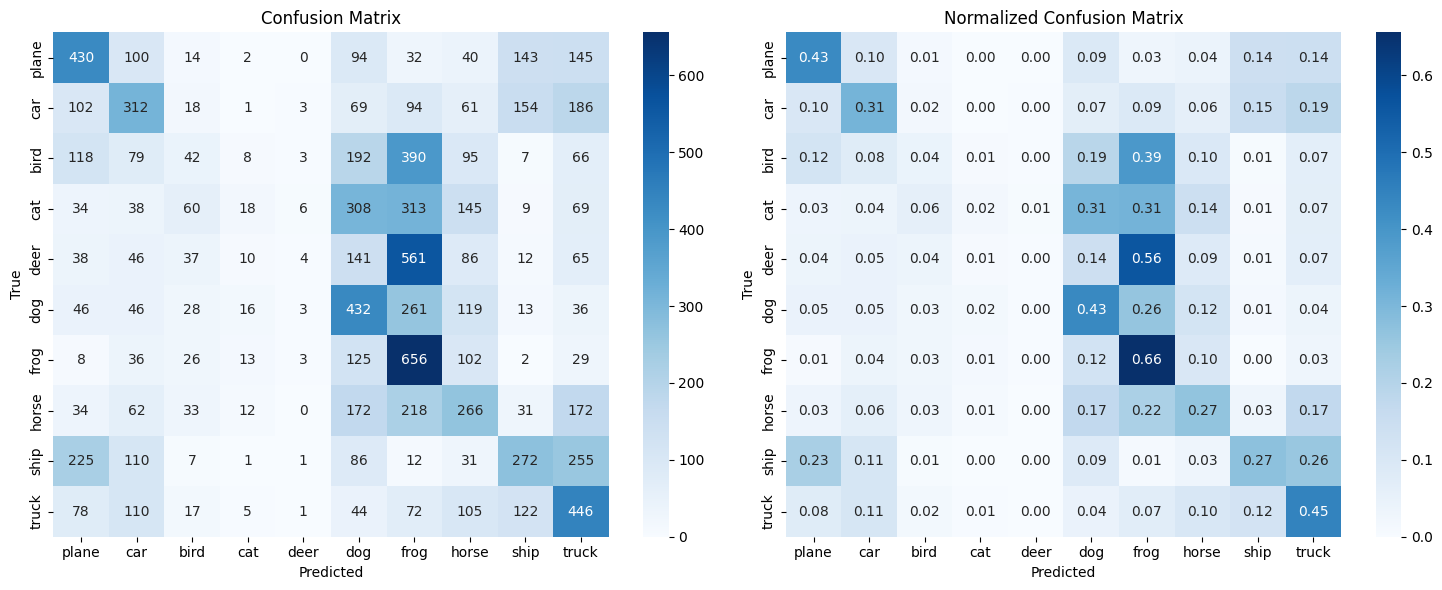

In [ ]:
plot_confusion_matrix(all_labels, all_preds, classes)

In [ ]:
# 클래스별 정확도 출력
print("\nPer-class Accuracy:")
for i in range(10):
    mask = np.array(all_labels) == i
    class_acc = (np.array(all_preds)[mask] == np.array(all_labels)[mask]).mean()
    print(f"{classes[i]}: {class_acc:.4f}")


Per-class Accuracy:
plane: 0.4300
car: 0.3120
bird: 0.0420
cat: 0.0180
deer: 0.0040
dog: 0.4320
frog: 0.6560
horse: 0.2660
ship: 0.2720
truck: 0.4460
